## Function for Cross Validation

In [6]:
# Import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
# Import confusion matrix, accuracy score
from sklearn.metrics import confusion_matrix, accuracy_score

def cross_validate(model, X, y, cv=10):

    # Let's split data into 10 folds with stratisfied sampling
    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)

    # Let's create a dictionary to store the scores
    scores = {}
    
    # Let's iterate over the folds
    i = 1
    for train_index, test_index in kf.split(X, y):
        
        # Let's split the data into train and test
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        y_train_vals = y_train.values
        # Convert in 1D array
        y_train_vals = y_train_vals.reshape(-1)

        # Let's fit the model
        model.fit(X_train.values, y_train_vals)
        
        # Let's predict the test data
        y_pred = model.predict(X_test.values)
        
        # Let's calculate the accuracy score
        acc = accuracy_score(y_test, y_pred)

        # Let's calculate the confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Let's append the score to the list
        scores[f'Fold-{i}'] = {'accuracy': acc, 'confusion_matrix': cm}
        i += 1

    # Let's return the scores
    return scores

## KNN Classifier Class

In [7]:
# Implement the KNN algorithm classifier without using the sklearn library
class KNNClassifier:

  # Constructor Function for our class
    def __init__(self, k=5, method='U'):

        self.k = k  # by default k = 5
        self.X_train = None # class prototypes
        self.y_train = None # labels
        self.isFirst = True
        self.pre_dis = dict()
        self.method = method
    

    # Training Function 
    def fit(self, X, y):

        # make sure that X is a 2D array and Y is a 1D array else raise an error 
        if len(X.shape) != 2 and len(y.shape) != 1:
            raise Exception("Error: X must be a 2D array")

        self.X_train = X
        self.y_train = y
    
    # Optimized predict function for HyperTuning using a fixed validation set
    def hyper_tuning_predict(self, X, method='U'):
        # Method parameter decides if we want to do a weighted (W) prediction or an unweighted (U) prediction
        # By default, we do an unweighted prediction
        if len(X.shape) != 2:
          raise Exception("Error: X must be a 2D array")
        
        if(str(method).lower() != 'u' and str(method).lower() != 'w'):
          raise Exception("Error: Please select a valid method : (U/W)")
        
        y_pred = []

        if(str(method).lower() == 'u'):
          for i in range(len(X)):
              # predicting the labels of all the feacture vector one by one
              label = self.hyper_tuning_predict_one(X[i], i)
              y_pred.append(label)
        else:
          for i in range(len(X)):
              # predicting the labels of all the feacture vector one by one
              label = self.hyper_tuning_predict_one_Weighted(X[i], i)
              y_pred.append(label)
        self.isFirst = False
        return y_pred

    # Unweighted Single Prediction Method for HyperTuning
    def hyper_tuning_predict_one(self, row, j):

      if(self.isFirst):
        for i in range(len(self.X_train)):
          dist = self.distance(row, self.X_train[i])
          if(self.pre_dis.get(j) != None):
            self.pre_dis[j].append((dist, self.y_train[i]))
          else:
            self.pre_dis[j] = [(dist, self.y_train[i])]

        # Sorting the distance array 
        self.pre_dis[j].sort()

      neighbors = self.pre_dis[j][:self.k]

      weights = dict()
      freq = dict()
      maxfreq = 0
      
      # Calculating the Weights

      for i in range(len(neighbors)):
        label = neighbors[i][1]
        if weights.get(label) is not None:
          weights[label] += neighbors[i][0]
          freq[label] += 1
        else:
          weights[label] = neighbors[i][0]
          freq[label] = 1
        
        maxfreq = max(maxfreq, freq[label])
      
      minWeight = -1
      answer_label = 0

      # Finding the label with minimum weight.
      # Weight of a label is basically the sum of all distances from datapoints of that label
      # This significanty decreases the chances of a Tie.
      for key, val in weights.items():
        if((minWeight == -1 or minWeight > val) and freq[key] == maxfreq):
          answer_label = key
          minWeight = val

      return answer_label

      #Extracting labels of k nearest neighbor
      # labels = [neighbor[1] for neighbor in neighbors]
      # return max(set(labels), key=labels.count)
    

    # Weighted Single Prediction method for hyperTuning
    def hyper_tuning_predict_one_Weighted(self, row, j):
      
      if(self.isFirst):
        for i in range(len(self.X_train)):
          dist = self.distance(row, self.X_train[i])
          if(self.pre_dis.get(j) != None):
            self.pre_dis[j].append((dist, self.y_train[i]))
          else:
            self.pre_dis[j] = [(dist, self.y_train[i])]
        
        # Sorting the distance array 
        self.pre_dis[j].sort()

      neighbors = self.pre_dis[j][:self.k]

      # Weight of neighbours
      weights = dict()

      # Calculating the Weights
      for i in range(len(neighbors)):
        label = neighbors[i][1]
        if weights.get(label) is not None:
          weights[label] += neighbors[i][0]
        else:
          weights[label] = neighbors[i][0]
      
      minWeight = -1
      answer_label = 0

      # Finding the label with minimum weight.
      # Weight of a label is basically the some of all distances from datapoints of that label
      # This significanty decreases the chances of a Tie.
      for key, val in weights.items():
        if(minWeight == -1 or minWeight > val):
          answer_label = key
          minWeight = val

      return answer_label


    # Function to predict the labels of array of Image
    def predict(self, X):

        method = self.method
        # Method parameter decides if we want to do a weighted (W) prediction or an unweighted (U) prediction
        # By default, we do an unweighted prediction
        if(str(method).lower() != 'u' and str(method).lower() != 'w'):
          raise Exception("Error: Please select a valid method : (U/W)")

        # make sure that X is a 2D array else return an error
        if len(X.shape) != 2:
            raise Exception("Error: X must be a 2D array")

        # Predictions array
        y_pred = []

        if(str(method).lower() == 'u'):
          for row in X:
              # predicting the labels of all the feacture vector one by one
              label = self.predict_one(row)
              y_pred.append(label)
        else:
          for row in X:
              # predicting the labels of all the feacture vector one by one
              label = self.predict_one_Weighted(row)
              y_pred.append(label)
        
        return y_pred
    
    # Predict the label of a single Image
    def predict_one(self, row):
        
        # Distance array
        distances = []

        # Looping over the feature vector
        for i in range(len(self.X_train)):
            dist = self.distance(row, self.X_train[i])
            distances.append((dist, self.y_train[i]))
        
        # Sorting the distance array 
        distances.sort()

        # Extracting first k neighbors
        neighbors = distances[:self.k]

        weights = dict()
        freq = dict()
        maxfreq = 0
        
        # Calculating the Weights

        for i in range(len(neighbors)):
          label = neighbors[i][1]
          if weights.get(label) is not None:
            weights[label] += neighbors[i][0]
            freq[label] += 1
          else:
            weights[label] = neighbors[i][0]
            freq[label] = 1
          
          maxfreq = max(maxfreq, freq[label])
        
        minWeight = -1
        answer_label = 0

        # Finding the label with minimum weight.
        # Weight of a label is basically the sum of all distances from datapoints of that label
        # This significanty decreases the chances of a Tie.
        for key, val in weights.items():
          if((minWeight == -1 or minWeight > val) and freq[key] == maxfreq):
            answer_label = key
            minWeight = val

        return answer_label

    # Precit the label of a feature vector based on weighted KNN
    def predict_one_Weighted(self, row):
        
        # Distance array
        distances = []

        # Looping over the feature vector
        for i in range(len(self.X_train)):
            dist = self.distance(row, self.X_train[i])
            distances.append((dist, self.y_train[i]))
        
        # Sorting the distance array 
        distances.sort()

        # Extracting first k neighbors
        neighbors = distances[:self.k]

        # Weight of neighbours
        weights = dict()
        
        # Calculating the Weights
        for i in range(len(neighbors)):
          label = neighbors[i][1]

          if weights.get(label) is not None:
            weights[label] += neighbors[i][0]
            
          else:
            weights[label] = neighbors[i][0]
        
        minWeight = -1
        answer_label = 0

        # Finding the label with minimum weight.
        # Weight of a label is basically the sum of all distances from datapoints of that label
        # This significanty decreases the chances of a Tie.
        for key, val in weights.items():
          if(minWeight == -1 or minWeight > val):
            answer_label = key
            minWeight = val

        return answer_label
    
    # Function to find Euclidian distance between two feature vector
    def distance(self, a, b):
        return np.linalg.norm(a - b)   

## Creating a Sample Dataset

In [8]:
# Randomly Generate 2d data, 1000 samples, 2 classes, 2 features
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=0)

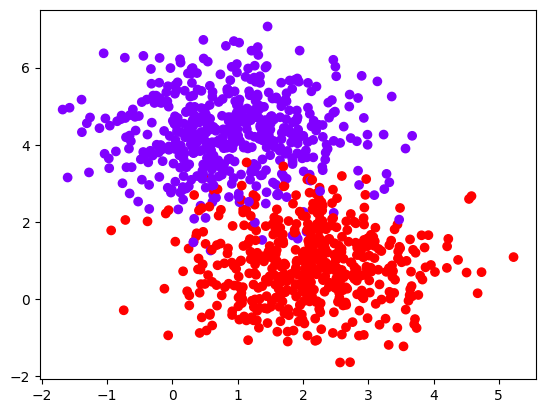

In [16]:
# Plot the data
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
plt.show()

Training KNN

In [18]:
import numpy as np
import pandas as pd

df_x = pd.DataFrame(X)
df_y = pd.DataFrame(y)

In [19]:
df_x.head()

,0,1
0,0.466618,3.865713
1,2.843828,3.326509
2,0.611215,2.512460
3,3.816534,1.651759
4,1.280972,0.628274


In [20]:
df_y.head()

,0
0,0
1,0
2,0
3,1
4,1


In [32]:
scores = {}

In [33]:
# Cross validate our model
for k in range(1, 10):
    print("K = ", k)
    scores[k] = cross_validate(KNNClassifier(k=k), df_x, df_y, cv=10)

K =  1
K =  2
K =  3
K =  4
K =  5
K =  6
K =  7
K =  8
K =  9


In [34]:
accuracies = []

# Find the best K
best_k = 0
best_score = 0
for k, score in scores.items():
    # Loop for all folds
    acc = 0
    for fold in score:
        acc += score[fold]['accuracy']
    acc /= 10
    print("K = ", k, " Accuracy = ", acc)
    if acc > best_score:
        best_score = acc
        best_k = k
    accuracies.append(acc)

K =  1  Accuracy =  0.942
K =  2  Accuracy =  0.942
K =  3  Accuracy =  0.9510000000000002
K =  4  Accuracy =  0.9540000000000001
K =  5  Accuracy =  0.9530000000000001
K =  6  Accuracy =  0.9550000000000001
K =  7  Accuracy =  0.9540000000000001
K =  8  Accuracy =  0.9570000000000002
K =  9  Accuracy =  0.9550000000000001


Plotting Accuracies

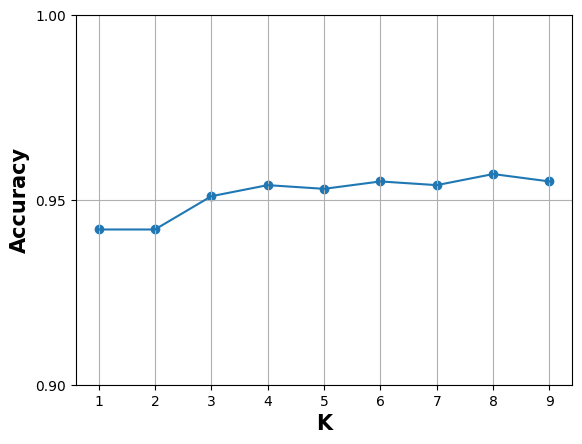

In [45]:
import matplotlib.pyplot as plt
plt.plot(range(1, 10), accuracies)
plt.scatter(range(1, 10), accuracies)
# Set y_ticks from 5 to 10
plt.yticks(np.arange(0.9, 1.01, 0.05))

# Set x and y labels and bold
plt.xlabel("K", fontsize=15, fontweight='bold')
plt.ylabel("Accuracy", fontsize=15, fontweight='bold')

plt.grid()
plt.show()